<a href="https://colab.research.google.com/github/Taikatou/economy-monte-carlo/blob/main/exp_3_craftsman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from gym import spaces, Env

In [ ]:
from enum import IntEnum

class ResourceType(IntEnum):
    WOOD = 1
    METAL = 2
    GEM = 3
    DRAGONSCALE = 4

class SwordType(IntEnum):
    BEGINNER = 1
    INTERMEDIATE = 2
    ADVANCED = 3
    EPIC = 4
    ULTIMATE = 5


In [ ]:
import random

class MarketplaceEnv:
    def __init__(self, price_increase_factor=0.1, price_decrease_factor=3, min_price=1, max_price=5000):
        self.price_increase_factor = price_increase_factor
        self.price_decrease_factor = price_decrease_factor
        self.min_price = min_price
        self.max_price = max_price
        self.resource_prices = {
            ResourceType.WOOD: 1.0,
            ResourceType.METAL: 2.0,
            ResourceType.GEM: 4.0,
            ResourceType.DRAGONSCALE: 5.0
        }
        self.sword_prices = {
            SwordType.BEGINNER: 10.0,
            SwordType.INTERMEDIATE: 20.0,
            SwordType.ADVANCED: 30.0,
            SwordType.EPIC: 40.0,
            SwordType.ULTIMATE: 50.0,
        }
        self.price_history = {
            'resource_prices': [],
            'sword_prices': []
        }
        self.counter = 0
        self.transaction_history = {'resource_transactions': {}, 'sword_transactions': {}}
        self.sales_count = {sword_type: 0 for sword_type in SwordType}  # Initialize sales count for each sword type

    def decay_sales_count(self):
        decay_factor_per_step = 0.99  # Smaller decay factor for per-step decay
        for sword_type in self.sales_count:
            self.sales_count[sword_type] *= decay_factor_per_step
            self.sales_count[sword_type] = max(1, self.sales_count[sword_type])  # Ensure sales_count doesn't go below 1

    def randomize_prices(self):
        # Randomize prices within the given range
        resource_price_range = {
            ResourceType.WOOD: (5, 10),
            ResourceType.METAL: (10, 15),
            ResourceType.GEM: (15, 25),
            ResourceType.DRAGONSCALE: (25, 35)
        }
        sword_price_range = {
            SwordType.BEGINNER: (30, 50),
            SwordType.INTERMEDIATE: (40, 70),
            SwordType.ADVANCED: (70, 120),
            SwordType.EPIC: (100, 180),
            SwordType.ULTIMATE: (120, 250)
        }
        # Randomize resource prices
        for resource_type in self.resource_prices:
            self.resource_prices[resource_type] = random.uniform(*resource_price_range[resource_type])

        # Randomize sword prices
        for sword_type in self.sword_prices:
            self.sword_prices[sword_type] = random.uniform(*sword_price_range[sword_type])

        self.counter += 1

    def get_will_randomize(self):
        randomize =  self.counter % 30 == 0
        self.counter += 1
        return randomize

    def get_sword_price(self, sword_type):
        return self.sword_prices[sword_type]

    def get_resource_prices(self):
        return self.resource_prices

    def sell_sword(self, sword_type, current_step):
        # ... code to handle selling the sword ...
        # Record the transaction
        if sword_type not in self.transaction_history['sword_transactions']:
            self.transaction_history['sword_transactions'][sword_type] = []
        self.transaction_history['sword_transactions'][sword_type].append((current_step, self.sword_prices[sword_type]))

    def get_price_change_factor(self, sword_type):
        sales_count = self.sales_count[sword_type]

        # Calculate the price change factor inversely proportional to the sales count
        # Adding 1 to avoid division by zero
        price_change_factor = 1 / (sales_count + 1)
        return price_change_factor

    def update_prices(self):
        # Decrease prices for resources
        for resource_type, price in self.resource_prices.items():
            decrease_amount = np.random.uniform(-self.price_decrease_factor, self.price_decrease_factor) / 2
            self.resource_prices[resource_type] = min(self.max_price, max(self.min_price, price + decrease_amount))

        # Increase prices for swords
        for sword_type, price in self.sword_prices.items():
            decrease_amount = np.random.uniform(-self.price_decrease_factor, self.price_decrease_factor)
            # Get the current sales count for the sword

            decrease_amount *= self.get_price_change_factor(sword_type)
            self.sword_prices[sword_type] = min(self.max_price, max(self.min_price, price + decrease_amount))

        # Record the prices after update
        self.price_history['resource_prices'].append(self.resource_prices.copy())
        self.price_history['sword_prices'].append(self.sword_prices.copy())

    def update_resource_price(self, resource_type):
        if resource_type in self.resource_prices:
            # Increase price by a factor, ensuring it doesn't fall below the minimum price
            increase_amount = np.random.uniform(0, self.price_increase_factor)
            self.resource_prices[resource_type] = min(
                self.min_price,
                self.resource_prices[resource_type] + increase_amount
            )

    def update_sword_price(self, sword_type):
        # Increase price by a factor, ensuring it doesn't fall below the minimum price
        increase_amount = np.random.uniform(0, self.price_increase_factor)
        increase_amount *= self.get_price_change_factor(sword_type)
        if sword_type in self.sword_prices:
            # Increase price by a factor, ensuring it doesn't fall below the minimum price
            self.sword_prices[sword_type] = min(
                self.max_price,
                self.sword_prices[sword_type] - (increase_amount*3)
            )
            # print(output + "\t" + str(self.sword_prices[sword_type]))

    def give_resource(self, resource_type, inventory, current_step):
        if resource_type in self.resource_prices:
            cost = self.resource_prices[resource_type]
            inventory.add_item(resource_type, 1, cost)
            if resource_type not in self.transaction_history['resource_transactions']:
                self.transaction_history['resource_transactions'][resource_type] = []
            self.transaction_history['resource_transactions'][resource_type].append((current_step, self.resource_prices[resource_type]))
            return cost
        return 0

    def get_resource_price(self, resource_type):
        return self.resource_prices[resource_type]

# Initialize the shared marketplace environment
marketplace_env = MarketplaceEnv()

In [ ]:
class AcquiredResource:
    def __init__(self, resource_type, acquisition_price):
        self.resource_type = resource_type
        self.acquisition_price = acquisition_price

In [ ]:
class Inventory:
    def __init__(self, crafting_requirements):
        self.resources = {}
        self.swords = {}
        self.sale_account = {}
        self.crafting_requirements = crafting_requirements
        self.reset()

    def set_crafting_requirements(self, new_requirements):
        self.crafting_requirements = new_requirements

    def add_item(self, resource_type, quantity, cost):
        if resource_type not in self.resources:
            self.resources[resource_type] = []
        acquiredResource = AcquiredResource(resource_type, cost)

        self.resources[resource_type].append(acquiredResource)

    def reset(self):
        self.resources = {ResourceType.WOOD: [],
                          ResourceType.METAL: [],
                          ResourceType.GEM: [],
                          ResourceType.DRAGONSCALE: []}
        self.swords = {SwordType.BEGINNER: 0,
                        SwordType.INTERMEDIATE: 0,
                        SwordType.ADVANCED: 0,
                        SwordType.EPIC: 0,
                        SwordType.ULTIMATE: 0}

    def craft(self, item):
        cost = 0
        if item in self.crafting_requirements:
            # Check if there are enough resources to craft the item
            for resource, amount_required in self.crafting_requirements[item].items():
                if len(self.resources[resource]) < amount_required:
                    return False  # Not enough resources to craft the item

            # Deduct resources used for crafting
            for resource, amount_required in self.crafting_requirements[item].items():
                for x in range(amount_required):
                    acquiredResource = self.resources[resource].pop()
                    cost += acquiredResource.acquisition_price

            # Add the crafted item to the inventory
            self.swords[item] += 1
            return cost
        else:
            return cost  # Item cannot be crafted (not in crafting requirements)

In [ ]:
class CraftingSellingEnv(Env):
    def __init__(self, marketplace_env, crafting_requirements, inflation_rate, max_steps_per_episode=5000):
        super(CraftingSellingEnv, self).__init__()
        self.marketplace_env = marketplace_env
        self.action_space = spaces.MultiDiscrete([5, 6])  # Resource collection and crafting/selling actions

        self.resources = np.zeros(4, dtype=np.int32)
        self.money = 100.0  # Starting money
        self.inventory = Inventory(crafting_requirements)
        # Define the observation space (flattened)
        num_resources = 4  # Number of resources
        num_swords = 5  # Number of sword types
        num_resource_prices = 4  # Number of market prices for resources
        num_swords_prices = 5  # Number of market prices for resources
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(num_resources + num_resource_prices + num_swords_prices + 1,), dtype=np.float32)
        self.max_steps_per_episode = max_steps_per_episode
        self.current_step = 0
        self.initial_prices = self.marketplace_env.sword_prices.copy()
        self.inflation_rate = inflation_rate
        self.sword_inflation_rates = {sword_type: [] for sword_type in SwordType}  # Initialize empty lists for each sword type


    def cooperative_crafting(self, partner_env, item_to_craft):
        # Check if both agents have the required resources for a joint craft
        own_requirements_met = all(self.inventory.items[res] >= req for res, req in self.inventory.crafting_requirements[item_to_craft].items())
        partner_requirements_met = all(partner_env.inventory.items[res] >= req for res, req in partner_env.inventory.crafting_requirements[item_to_craft].items())

        if own_requirements_met and partner_requirements_met:
            # Craft the item and share the rewards
            self.inventory.craft(item_to_craft)
            partner_env.inventory.craft(item_to_craft)
            shared_reward = self.marketplace_env.get_sword_price(SwordType[item_to_craft]) / 2
            return shared_reward
        return 0

    def step(self, action):
        self.marketplace_env.update_prices()
        resource_action, sell_action = action
        resources_chosen = [False] * 4
        reward = 0

        if resource_action > 0:
            resource_type = ResourceType(resource_action)
            if self.money >= self.marketplace_env.get_resource_price(resource_type):
                cost = self.marketplace_env.give_resource(resource_type, self.inventory, self.current_step)
                self.marketplace_env.update_resource_price(resource_type)
                self.money -= cost  # Deduct the cost of the resource from the agent's money

        # Placeholder for reward and done logic

        if sell_action > 0:
            sword = SwordType(sell_action)
            cost = self.inventory.craft(sword)
            if self.inventory.swords[sword] > 0:
                self.marketplace_env.sell_sword(sword, self.current_step)
                income = self.sell_sword(sword)
                self.marketplace_env.update_sword_price(sword)
                reward += (income-cost) / (self.marketplace_env.max_price)

        self.current_step += 1
        if self.current_step >= self.max_steps_per_episode:
            done = True
        else:
            done = False
        self.marketplace_env.decay_sales_count()
        return self._get_obs(), reward, done, {}

    def sell_sword(self, sword_type):
        self.inventory.swords[sword_type] -= 1  # Remove one sword from inventory
        selling_price = self.marketplace_env.sword_prices[sword_type]
        self.money += selling_price  # Add money to the wallet based on current price
        return selling_price  # Return the income from selling the sword

    def calculate_inflation(self):
        # Assuming the dictionaries contain the average prices of each item at two different times
        if not self.initial_prices or not self.marketplace_env.sword_prices:
            return 0  # Avoid division by zero

        # Calculate the sum of initial and current prices
        sum_initial = sum(self.initial_prices.values())
        sum_current = sum(self.marketplace_env.sword_prices.values())
        # Calculate the inflation rate
        inflation_rate = ((sum_current - sum_initial) / sum_initial) * 100
        print("inflation rate is " + str(inflation_rate))
        self.inflation_rate.append(inflation_rate)
        return inflation_rate


    def reset(self):
        for sword_type in SwordType:
            initial_price = self.initial_prices[sword_type]
            final_price = self.marketplace_env.sword_prices[sword_type]
            inflation_rate = ((final_price - initial_price) / initial_price) * 100 if initial_price else 0
            self.sword_inflation_rates[sword_type].append(inflation_rate)
        self.resources = np.zeros(4, dtype=np.int32)
        if self.marketplace_env.get_will_randomize():
            inflation_rate = self.calculate_inflation()
            self.marketplace_env.randomize_prices()
            # Reset initial prices for the next episode
            self.initial_prices = self.marketplace_env.sword_prices.copy()

        self.money = 100.0
        self.inventory.reset()
        self.current_step = 0
        # Calculate inflation at the end of an episode before reset

        return self._get_obs()

    def _get_obs(self):
        # Flatten all observations into a single array
        resource_obs = []
        for key, value in self.inventory.resources.items():
            resource_obs.append(len(value))
        resource_obs = np.array(resource_obs)  # First 4 are resources
        resource_prices_obs = np.array(list(self.marketplace_env.get_resource_prices().values()))
        sword_prices_obs = np.array(list(self.marketplace_env.sword_prices.values()))
        money_obs = np.array([self.money])
        observations = np.concatenate((resource_obs, resource_prices_obs, sword_prices_obs, money_obs), axis=0)
        return observations

    def calculate_efficiency_metrics(self):
        # Assume we have logs of decisions and rewards
        average_decision_time = np.mean(self.decision_times)
        items_crafted = sum(self.inventory.items[sword] for sword in ['BeginnerSword', 'IntermediateSword', 'AdvancedSword'])
        liquidity = np.mean([self.marketplace_env.resource_prices[res] for res in ResourceType])

        efficiency_metrics = {
            'average_decision_time': average_decision_time,
            'items_crafted': items_crafted,
            'liquidity': liquidity,
            'total_reward': self.total_reward
        }
        return efficiency_metrics

    def render(self, mode='human', close=False):
        # Optional: Implement rendering logic
        pass

In [ ]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

/home/taikatou/anaconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback

In [ ]:
class RewardLoggerCallback(BaseCallback):
    def __init__(self, check_freq):
        super(RewardLoggerCallback, self).__init__()
        self.check_freq = check_freq
        self.rewards = []

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            episode_rewards = self.model.ep_info_buffer
            if episode_rewards:
                self.rewards.append(episode_rewards[-1]['r'])
                print(episode_rewards[-1]['r'])
        return True

In [ ]:
crafting_requirements = {
    SwordType.BEGINNER: {ResourceType.WOOD: 2, ResourceType.METAL: 1},
    SwordType.INTERMEDIATE: {ResourceType.WOOD: 1, ResourceType.METAL: 2},
    SwordType.ADVANCED: {ResourceType.GEM: 1, ResourceType.WOOD: 1, ResourceType.METAL: 1},
    SwordType.EPIC: {ResourceType.GEM: 1, ResourceType.WOOD: 0, ResourceType.METAL: 2},
    SwordType.ULTIMATE: {ResourceType.GEM: 1, ResourceType.METAL: 1, ResourceType.DRAGONSCALE: 1}
}
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

reward_logger = RewardLoggerCallback(check_freq=5000)
inflation_rates = []
# Instantiate the agent
env = make_vec_env(lambda: CraftingSellingEnv(marketplace_env, crafting_requirements, inflation_rates), n_envs=24)

model = PPO('MlpPolicy', env, verbose=6, clip_range=0.2)

if False:
    # Train the agent
    model.learn(total_timesteps=int(1e7), callback=reward_logger)
    model.save("econ")
else:
    model = PPO.load("econ")

Using cpu device


/home/taikatou/anaconda3/envs/tf/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
# Create a dummy input for the export
import torch
input_shape = (14,)
dummy_input = torch.randn(1, *input_shape)  # Adjust the shape accordingly

# Export the model
torch.onnx.export(model.policy,  # The model's policy network
                  dummy_input,
                  "econ.onnx",  # Output path
                  export_params=True,
                  opset_version=10,  # Adjust based on your needs
                  do_constant_folding=True,
                  input_names=['input'],  # Names should match model's input
                  output_names=['output'],  # And output
                  dynamic_axes={'input': {0: 'batch_size'},  # For variable batch size
                                'output': {0: 'batch_size'}})

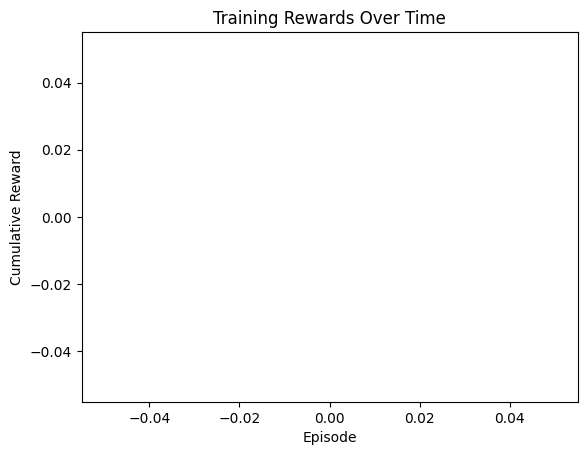

In [ ]:
# Plot the rewards
plt.plot(reward_logger.rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Training Rewards Over Time')
plt.show()


In [ ]:
marketplace_env.price_history = {
            'resource_prices': [],
            'sword_prices': []
        }
marketplace_env.transaction_history = {'resource_transactions': {}, 'sword_transactions': {}}
inflation_rates = []
env = make_vec_env(lambda: CraftingSellingEnv(marketplace_env, crafting_requirements, inflation_rates), n_envs=24)
#model.learn(total_timesteps=int(4e8), callback=reward_logger)

In [ ]:
randGen = False

steps = 0
if not randGen:
    num_steps = 1e7  # Number of steps you want to run the policy
    obs = env.reset()

    for steps in range(int(num_steps)):
        actions, _ = model.predict(obs)
        obs, rewards, dones, info = env.step(actions)
    env.close()

inflation rate is 0.0
inflation rate is -8.058942158311279
inflation rate is 136.90033387633818
inflation rate is 66.22423508593661
inflation rate is 44.50814414947407
inflation rate is -3.828522589676891
inflation rate is -38.044184509086
inflation rate is -10.881677533439511
inflation rate is -44.07703219793959
inflation rate is -46.37571110034362
inflation rate is -2.6539662680722653
inflation rate is -33.357291563881574
inflation rate is -7.733749066910418
inflation rate is -54.596987028804655
inflation rate is -4.757828459069093
inflation rate is -27.831117480886842
inflation rate is -11.422010891282437
inflation rate is -19.694688697849056
inflation rate is 7.779965541458004
inflation rate is 70.49252463419661
inflation rate is -0.8778600061571414
inflation rate is 7.140096800157769
inflation rate is -19.242745175077268
inflation rate is -5.123660477794356
inflation rate is 104.82136654974433
inflation rate is -3.4234363077132626
inflation rate is -8.714125077921699
inflation rat

In [ ]:
import matplotlib.pyplot as plt

def simulate_data(env, random):
    all_sword_inflation_rates = [single_env.sword_inflation_rates for single_env in env.envs]

    # Assuming SwordType is an Enum
    average_sword_inflation_rates = {sword_type: [] for sword_type in SwordType}

    # Calculate the average inflation rate for each sword type at each time step
    for sword_type in SwordType:
        # Extract inflation rates for the current sword type from all environments
        sword_inflation_rates_all_envs = [env_rates[sword_type] for env_rates in all_sword_inflation_rates]

        # Calculate the average at each time step
        for i in range(len(sword_inflation_rates_all_envs[0])):  # Assuming all envs have the same number of steps
            avg_rate = np.mean([env_rates[i] for env_rates in sword_inflation_rates_all_envs])
            average_sword_inflation_rates[sword_type].append(avg_rate)

    # Plot the average inflation rates over time for each sword type
    plt.figure(figsize=(12, 6))

    for sword_type, avg_inflation_rates in average_sword_inflation_rates.items():
        plt.plot(avg_inflation_rates, label=sword_type.name)  # Assuming SwordType has a 'name' attribute

    plt.title('Average Inflation Rate per Sword Type Over Time Across All Environments')
    plt.xlabel('Time Step')
    plt.ylabel('Average Inflation Rate (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

    from statistics import mean
    from scipy import stats
    from statistics import mean, stdev
    from math import sqrt

    colors = ['blue', 'green', 'red', 'purple', 'orange'] if random else ['lightblue', 'lightgreen', 'lightcoral', 'plum', 'yellow']

    # Extract sword types and their corresponding average inflation rates
    sword_types = average_sword_inflation_rates.keys()
    average_inflation_rates = average_sword_inflation_rates.values()

    # Extract sword types and their corresponding average inflation rates
    sword_types = average_sword_inflation_rates.keys()
    average_inflation_rates = average_sword_inflation_rates.values()

    # Calculate standard error of the mean for each sword type to determine the size of the confidence interval bars
    standard_errors = [stdev(inflations) / sqrt(len(inflations)) for inflations in average_inflation_rates]

    # Plot the average inflation rates as a bar chart with confidence bars
    plt.figure(figsize=(10, 6))
    sword_type_names = [sword_type for sword_type in sword_types]

    for i, (sword_type, inflation) in enumerate(average_sword_inflation_rates.items()):
        plt.bar(sword_type.name, mean(inflation), color=colors[i], yerr=standard_errors[i], capsize=5)

    title = "Average Inflation Rate per Sword Type " + ("Random Policy" if random else "Trained Policy")
    plt.title(title)
    plt.xlabel('Sword Type')
    plt.ylabel('Average Inflation Rate (%)')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [ ]:
num_steps = 1000000  # Number of steps to run

marketplace_env_b = MarketplaceEnv()
inflation_rates = []
env = make_vec_env(lambda: CraftingSellingEnv(marketplace_env_b, crafting_requirements, inflation_rates), n_envs=24)

In [ ]:
num_envs = 24

obs = env.reset()  # Reset the environment
for step in range(num_steps):
    # Generate random actions for each environment
    actions = [env.action_space.sample() for _ in range(num_envs)]

    # Take a step in the environment
    obs, rewards, dones, infos = env.step(actions)

    # Optionally: Do something with the observations, rewards, dones, infos...

    # Reset environments that are done
    for i in range(num_envs):
        if dones[i]:
            env.reset()

# Close the environment
env.close()

In [ ]:
simulate_data(env, randGen)

In [ ]:
sword_transactions = marketplace_env_b.transaction_history["sword_transactions"]
# Plot the transaction prices over time for each sword type
plt.figure(figsize=(12, 6))
for sword, transactions in sword_transactions.items():
    steps, prices = zip(*transactions)  # Separate the steps and prices

    # Group prices by steps and calculate average price per step
    unique_steps = sorted(set(steps))
    avg_prices = [np.mean([price for step, price in transactions if step == unique_step]) for unique_step in unique_steps]

    # Plot the average prices
    plt.plot(unique_steps, avg_prices, label=sword)


plt.title('Sword Transaction Prices Over Time')
plt.xlabel('Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Function to format the y-axis ticks into millions
from matplotlib.ticker import StrMethodFormatter

colors = ['blue', 'green', 'red', 'purple', 'orange'] if randGen else ['lightblue', 'lightgreen', 'lightcoral', 'plum', 'yellow']

# Calculate counts and a mock error for demonstration (assuming a static error for simplicity)
sword_counts = marketplace_env_b.transaction_history["sword_transactions"]
counts = [len(v) for v in sword_counts.values()]
errors = [np.std([item[1] for item in v]) for v in sword_counts.values()]  # Standard deviation of the float values

# Bar chart
fig, ax = plt.subplots()
x = np.arange(len(sword_counts))  # the label locations
bars = ax.bar(x, counts, color=colors, yerr=errors, capsize=5)
ax.set_xticks(x)
ax.set_xticklabels([type.name for type in SwordType])
ax.set_ylabel('Frequency of Sales')
ax.set_title('Frequency of Sales for Each Sword Type (Random Policy)')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()

In [ ]:
# Function to calculate average prices
def calculate_average_prices(transactions):
    steps, prices = zip(*transactions)
    unique_steps = sorted(set(steps))
    avg_prices = [np.mean([price for step, price in transactions if step == unique_step]) for unique_step in unique_steps]
    return unique_steps, avg_prices

# Plot the transaction prices over time for each sword type
plt.figure(figsize=(12, 6))

from concurrent.futures import ProcessPoolExecutor
# Use ProcessPoolExecutor to parallelize the calculation of average prices
with ProcessPoolExecutor() as executor:
    # Submit tasks to the executor
    futures = {sword: executor.submit(calculate_average_prices, transactions) for sword, transactions in sword_transactions.items()}

    # Collect and plot results as they are completed
    for sword, future in futures.items():
        unique_steps, avg_prices = future.result()
        plt.plot(unique_steps, avg_prices, label=sword)

plt.title('Sword Transaction Prices Over Time')
plt.xlabel('Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pygame
import sys
class UIEnvironment:
    def __init__(self, env):
        # Initialize Pygame and set up the screen
        pygame.init()
        self.screen = pygame.display.set_mode((800, 600))
        pygame.display.set_caption("Learning Environment UI")

        # Store the underlying environment
        self.env = env

        # Define colors
        self.bg_color = (50, 50, 50)
        self.text_color = (255, 255, 255)
        self.button_color = (0, 150, 0)

        # Load font
        self.font = pygame.font.Font(None, 36)

        # Define button properties
        self.button_width = 150
        self.button_height = 50
        self.button_margin = 10  # Margin between buttons
        self.button_font = pygame.font.Font(None, 24)  # Smaller font size for buttons

    def draw_text(self, name, value, position):
        text = f"{name}: {value}"
        text_surface = self.font.render(text, True, self.text_color)
        self.screen.blit(text_surface, position)

    def draw_text_money(self, text, position):
        text_surface = self.font.render(text, True, self.text_color)
        self.screen.blit(text_surface, position)


    def draw_button(self, text, position):
        # Define the button rectangle
        button_rect = pygame.Rect(position, (self.button_width, self.button_height))

        # Draw the button rectangle
        pygame.draw.rect(self.screen, self.button_color, button_rect)

        # Render the text with the smaller font
        text_surface = self.button_font.render(text, True, self.text_color)
        text_rect = text_surface.get_rect(center=button_rect.center)

        # Blit the text onto the screen at the center of the button
        self.screen.blit(text_surface, text_rect)

        return button_rect  # Return the rectangle in case we need it for button click detection

    def draw_resource_buttons(self):
        resource_buttons = {}
        resource_names = [resource.name for resource in ResourceType]  # Replace ResourceType with your enum
        button_x = 20
        button_y = 300  # Adjust as needed
        for resource_name in resource_names:
            button_rect = self.draw_button(resource_name, (button_x, button_y))
            resource_buttons[resource_name] = button_rect
            button_x += self.button_width + self.button_margin  # Move right for the next button
        return resource_buttons

    def draw_sword_buttons(self):
        sword_buttons = {}
        sword_names = [sword.name for sword in SwordType]  # Replace SwordType with your enum
        button_x = 20
        button_y = 400  # Adjust as needed
        for sword_name in sword_names:
            button_rect = self.draw_button(sword_name, (button_x, button_y))
            sword_buttons[sword_name] = button_rect
            button_x += self.button_width + self.button_margin  # Move right for the next button
        return sword_buttons

    def draw_money(self, money):
        # Define the position for the money display (top right corner)
        screen_width, _ = self.screen.get_size()
        position = (screen_width - 200, 20)  # Adjust these values as needed

        # Format the money display text
        money_text = f"Money: ${money:.2f}"  # Format with 2 decimal places

        # Draw the text on the screen
        self.draw_text_money(money_text, position)

    def draw_reward(self, reward):
        # Define the position for the reward display (bottom center)
        screen_width, screen_height = self.screen.get_size()
        position = (screen_width // 2, screen_height - 50)  # Adjust y-value as needed

        # Format the reward display text
        reward_text = f"Reward: {reward:.2f}"  # Format with 2 decimal places

        # Draw the text on the screen
        self.draw_text(reward_text, position)

    def run(self):
        counter = 0
        reward = 0
        while True:
            # Clear screen
            self.screen.fill(self.bg_color)

            resource_buttons = self.draw_resource_buttons()
            sword_buttons = self.draw_sword_buttons()

            action = (0, 0)

            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    sys.exit()
                elif event.type == pygame.MOUSEBUTTONDOWN:
                    # Check if a resource button was clicked
                    for resource_name, rect in resource_buttons.items():
                        if rect.collidepoint(event.pos):
                            action[0] = int(resource_name)
                    # Check if a sword button was clicked
                    for sword_name, rect in sword_buttons.items():
                        if rect.collidepoint(event.pos):
                            action[1] = int(resource_name)

            # Draw resource and sword prices
            resource_prices = self.env.marketplace_env.get_resource_prices()
            sword_prices = self.env.marketplace_env.sword_prices
            y_offset = 20  # Start 20 pixels from the top

            for resource, price in resource_prices.items():
                self.draw_text(resource.name, f": {price}", (20, y_offset))  # Updated call
                y_offset += 30  # Move down for the next text

            for sword, price in sword_prices.items():
                self.draw_text(sword.name, f": {price}", (20, y_offset))  # Updated call
                y_offset += 30  # Move down for the next text


            # Draw money
            money = self.env.money  # Assuming your environment has a method to get the current money
            self.draw_money(money)

            if counter % 20 == 0:
                obs, reward, done, _ = env.step(action)

            if show_reward > 0:
                self.draw_reward(current_reward)

            # Refresh screen
            pygame.display.flip()


env = CraftingSellingEnv(marketplace_env, crafting_requirements, inflation_rates)
ui_env = UIEnvironment(env)
ui_env.run()